<a href="https://colab.research.google.com/github/sttutie/Jungho-Shin/blob/main/linear_models_for_regression.ipynbipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns
import tensorflow as tf
import random
df = pd.read_csv( "https://raw.githubusercontent.com/sttutie/Jungho-Shin/main/auto-mpg.csv", sep=',')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

In [3]:
from sklearn.impute import KNNImputer

In [4]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


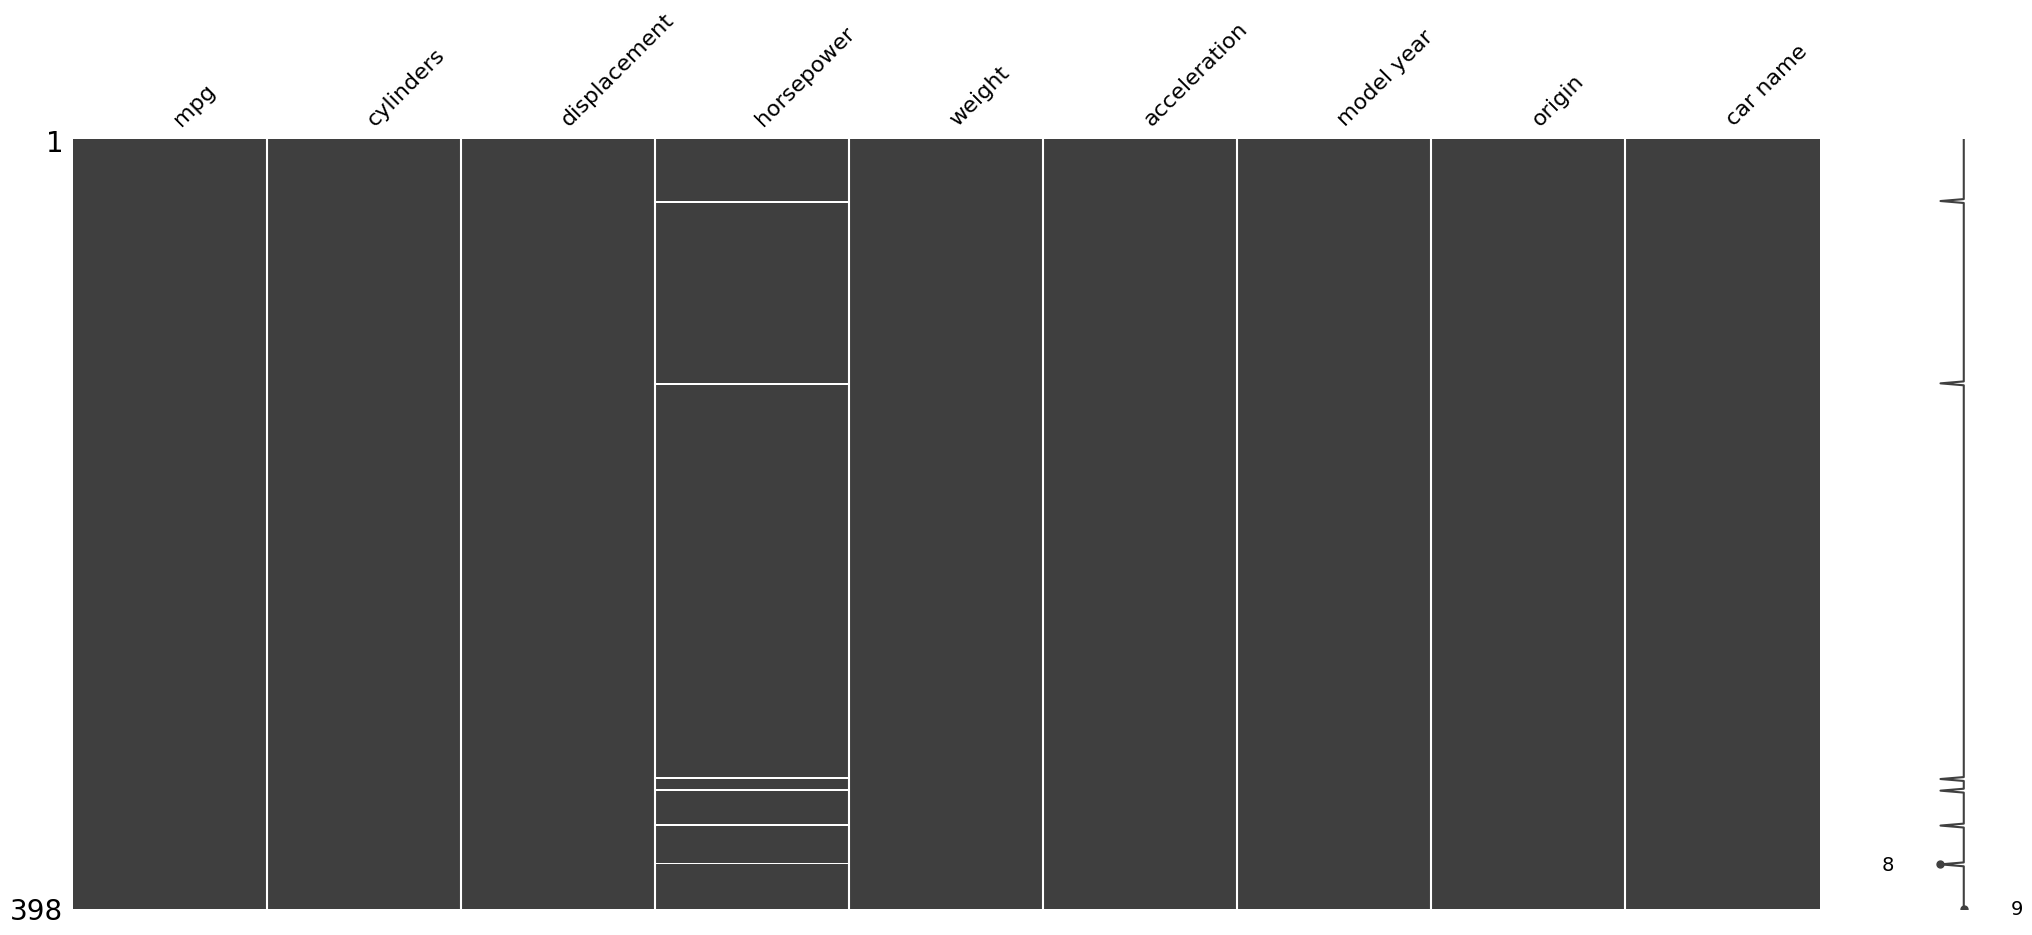

In [5]:
import missingno as msno
import matplotlib.pyplot as plt

df = df.replace('?', np.nan)

msno.matrix(df)
plt.show()

In [6]:
unique_car_count = df['car name'].nunique()
print("차종 갯수:", unique_car_count)

차종 갯수: 305


차종을 유지한 채, 학습시키면 무조건 차원의 저주가 문제가 될 것이다. 삭제하자

In [7]:
unique_origin_count = df['origin'].nunique()
print("origin 갯수:", unique_origin_count)

origin 갯수: 3


origin은 괜찮을 것 같다.

In [8]:
X_data = df.drop(['car name'], axis=1)

# KNNImputer로 결측치 채우기
imputer = KNNImputer(n_neighbors=5)  # K 값 설정 (5로 예시)
X_filled = imputer.fit_transform(X_data)

# 채워진 데이터로 새로운 데이터프레임 생성
df_filled = pd.DataFrame(X_filled, columns=X_data.columns)

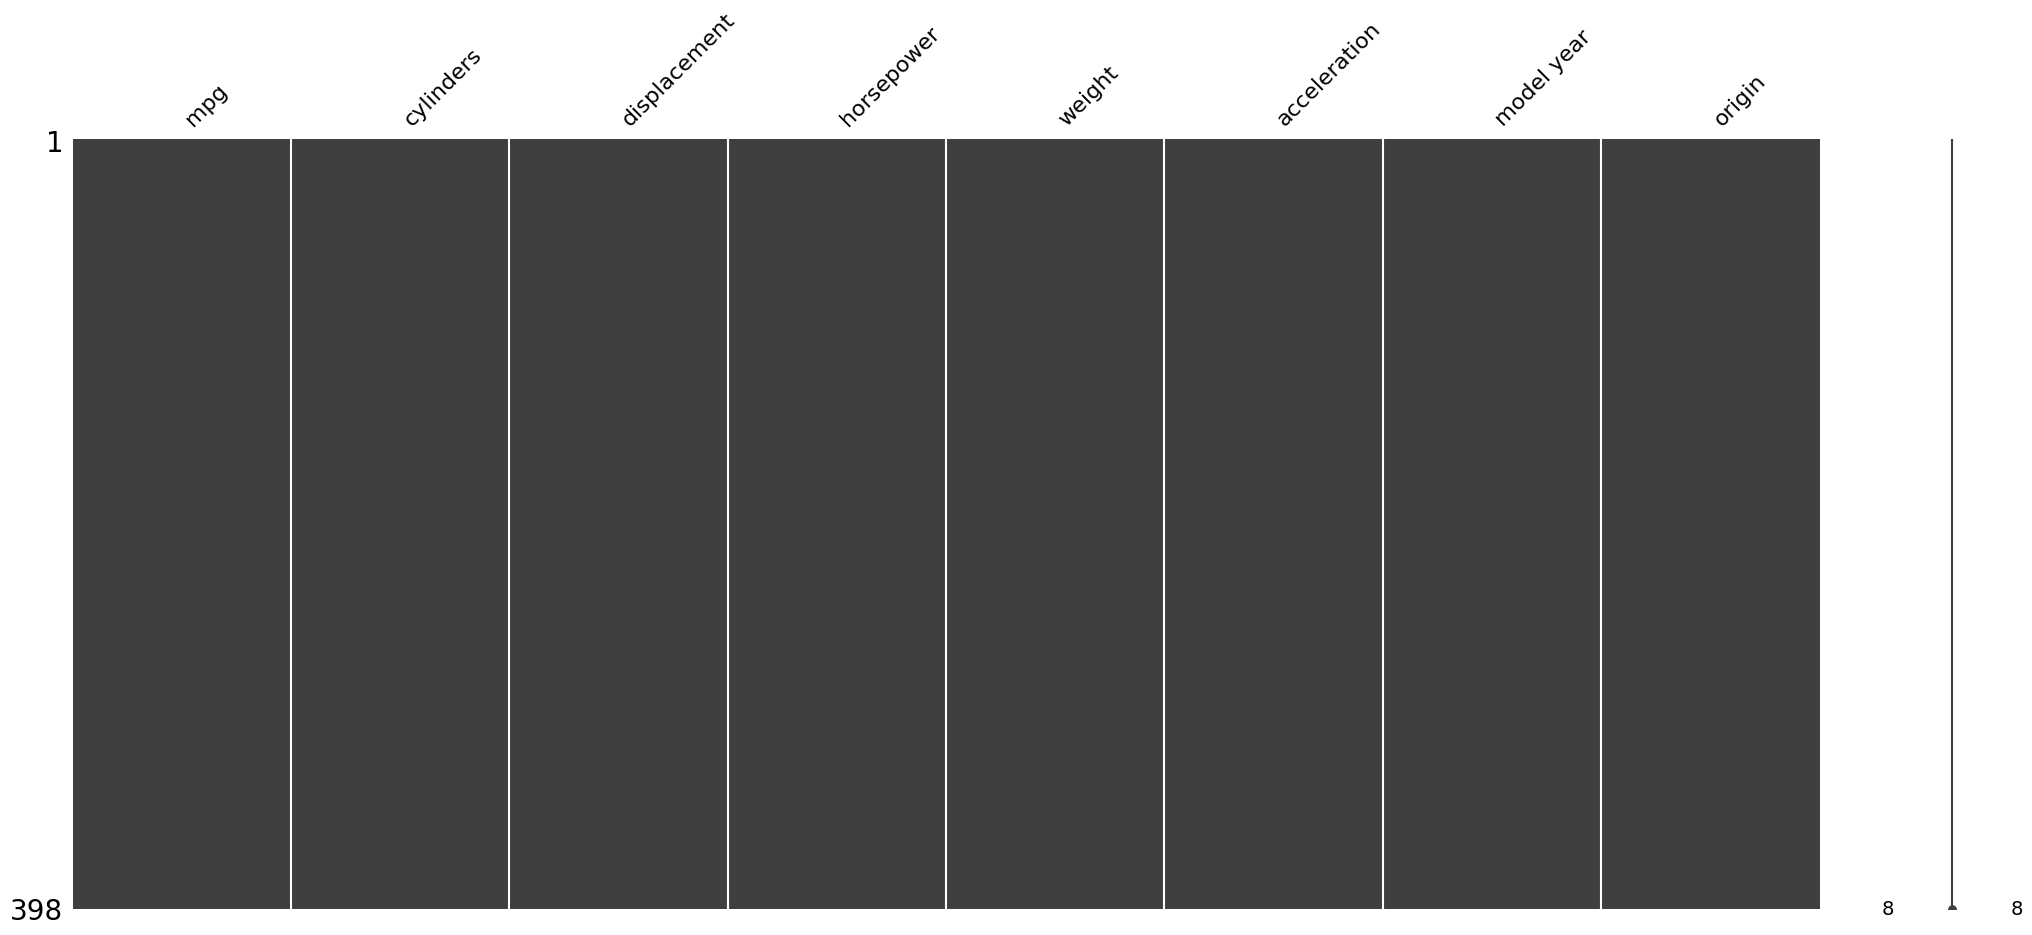

In [9]:
msno.matrix(df_filled)
plt.show()

In [10]:
df_filled.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0


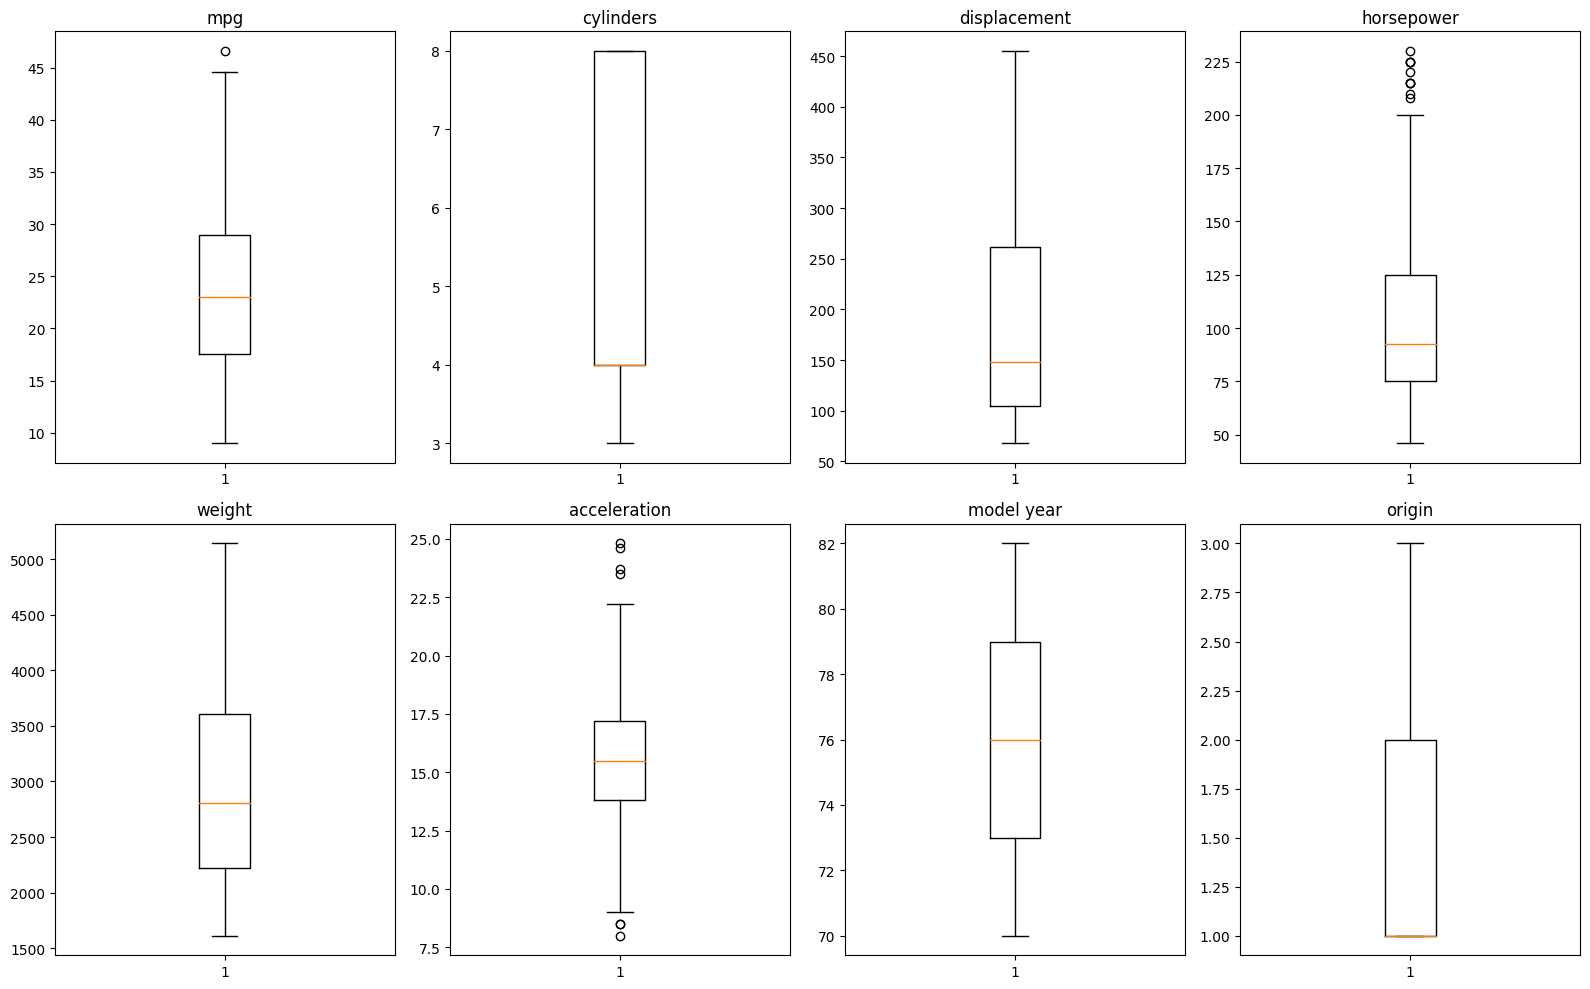

In [11]:
import matplotlib.pyplot as plt

mpg = df_filled['mpg']
cylinders = df_filled['cylinders']
displacement = df_filled['displacement']
horsepower = df_filled['horsepower']
weight = df_filled['weight']
acceleration = df_filled['acceleration']
model_year = df_filled['model year']
origin = df_filled['origin']

asd = [mpg, cylinders, displacement, horsepower, weight, acceleration, model_year, origin]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))
axes = axes.flatten()

for i, column in enumerate(asd):
    axes[i].boxplot(column)
    axes[i].set_title(column.name)

plt.tight_layout()
plt.show()

이상치가 최대 6개 밖에 없다. 한번 그냥 둬보자.


In [12]:
df_filled.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0


In [13]:
from sklearn.decomposition import PCA
X = df_filled[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']]
y = df_filled['mpg']

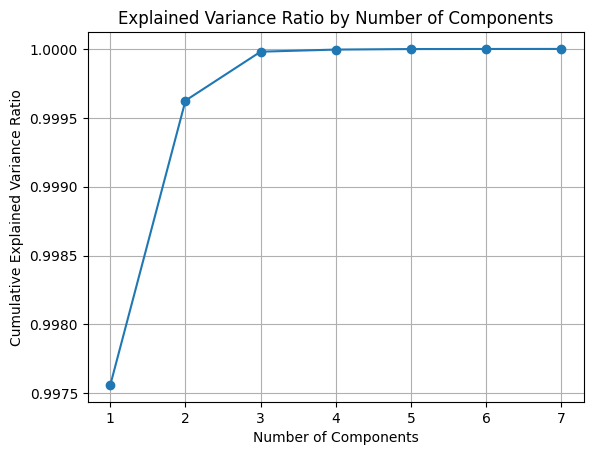

In [14]:
pca = PCA()
pca.fit(df_filled.drop('mpg', axis=1))

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

num_components = range(1, len(explained_variance_ratio) + 1)

plt.plot(num_components, cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.xticks(num_components)
plt.grid(True)
plt.show()

2개로 줄이자

with 표준화

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
from sklearn.metrics import mean_squared_error
cv_scores = []
degrees = [1, 2, 3, 4, 5]
k = 5
for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_pca)

    model = LinearRegression()
    scores = cross_val_score(model, X_train_poly, y_train, scoring='neg_mean_squared_error', cv=k)
    cv_scores.append(np.mean(-scores))

for degree, score in zip(degrees, cv_scores):
    print(f"다항식 차수: {degree}, MSE 스코어: {score}")

best_degree = degrees[np.argmin(cv_scores)]
print(f"최적 다항식 차수: {best_degree}")
poly_features = PolynomialFeatures(degree=best_degree)
X_train_poly = poly_features.fit_transform(X_train_pca)
X_test_poly = poly_features.transform(X_test_pca)

best_model = LinearRegression()
best_model.fit(X_train_poly, y_train)

test_score = mean_squared_error(y_test, best_model.predict(X_test_poly))
print(f"Test MSE Score: {test_score}")

다항식 차수: 1, MSE 스코어: 17.728090007861482
다항식 차수: 2, MSE 스코어: 13.088941883461942
다항식 차수: 3, MSE 스코어: 12.852754532103347
다항식 차수: 4, MSE 스코어: 13.29640687334665
다항식 차수: 5, MSE 스코어: 13.582294433522174
최적 다항식 차수: 3
Test MSE Score: 12.520383446810202


no 표준

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

pca = PCA(n_components=2)
X_train_pca1 = pca.fit_transform(X_train)
X_test_pca1 = pca.transform(X_test)

In [18]:
from sklearn.metrics import mean_squared_error
cv_scores = []
degrees = [1, 2, 3, 4, 5]
k = 5
for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_pca1)

    model = LinearRegression()
    scores = cross_val_score(model, X_train_poly, y_train, scoring='neg_mean_squared_error', cv=k)
    cv_scores.append(np.mean(-scores))

for degree, score in zip(degrees, cv_scores):
    print(f"다항식 차수: {degree}, MSE 스코어: {score}")

best_degree = degrees[np.argmin(cv_scores)]
print(f"최적 다항식 차수: {best_degree}")

다항식 차수: 1, MSE 스코어: 19.128142846537767
다항식 차수: 2, MSE 스코어: 16.856329678149756
다항식 차수: 3, MSE 스코어: 19.107238443106223
다항식 차수: 4, MSE 스코어: 540.1327239363263
다항식 차수: 5, MSE 스코어: 3220.8706116677727
최적 다항식 차수: 2


In [19]:
poly_features = PolynomialFeatures(degree=best_degree)
X_train_poly = poly_features.fit_transform(X_train_pca1)
X_test_poly = poly_features.transform(X_test_pca1)

best_model = LinearRegression()
best_model.fit(X_train_poly, y_train)

test_score = mean_squared_error(y_test, best_model.predict(X_test_poly))
print(f"Test MSE Score: {test_score}")

Test MSE Score: 16.124612767235696


파이프라인 PCA, 표준화 없이

In [20]:
from sklearn.pipeline import make_pipeline
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=22)

degrees = [1, 2, 3, 4, 5]
k = 5

pipeline = make_pipeline(
    PolynomialFeatures(include_bias=False),
    LinearRegression()
)

cv_scores = []
for degree in degrees:
    pipeline.set_params(polynomialfeatures__degree=degree)
    scores = -cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=k)
    cv_scores.append(np.mean(scores))

best_degree = degrees[np.argmin(cv_scores)]
best_score = np.min(cv_scores)

print(f"Best Degree: {best_degree}")
print(f"Best MSE Score: {best_score}")

best_model = make_pipeline(
    PolynomialFeatures(degree=best_degree, include_bias=False),
    LinearRegression()
)
best_model.fit(X_train, y_train)

test_score = mean_squared_error(y_test, best_model.predict(X_test))
print(f"Test MSE Score: {test_score}")

Best Degree: 2
Best MSE Score: 7.7805659011377815
Test MSE Score: 6.2093696741925095


릿지 규제. pca 없이

In [21]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
degree = 3
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train_std)
X_test_poly = poly_features.transform(X_test_std)

ridge = Ridge()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_poly, y_train)

best_model = grid_search.best_estimator_
best_alpha = best_model.alpha

test_score = mean_squared_error(y_test, best_model.predict(X_test_poly))

print(f"Best alpha: {best_alpha}")
print(f"Test MSE Score: {test_score}")

Best alpha: 10
Test MSE Score: 6.149391449239866


PCA 포함

In [22]:
degree = 3
alpha_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100]

poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train_pca)
X_test_poly = poly_features.transform(X_test_pca)

ridge = Ridge()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_poly, y_train)

best_model = grid_search.best_estimator_
best_alpha = best_model.alpha

test_score = mean_squared_error(y_test, best_model.predict(X_test_poly))

print(f"Best alpha: {best_alpha}")
print(f"Test MSE Score: {test_score}")

Best alpha: 10.0
Test MSE Score: 12.34072556835799


PCA가 만능은 아닌가보다.